# Adversarial Search: Playing Connect 4

Student Name: Dimitri Lavin

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: DL

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Initial State: The initial state is the empty 6x7 Connect4 grid.

Actions: Players place a game chip in one of the seven columns. The game chip will fall down to the lowest row available in that column. Game chips cannot be removed from Connect4 grid.

Transition model: 

    Result(current board, drop chip) = current board + new chip position

    Result(opponent with 3 in a row, opponent drops chip in winning position) = you lose

    Result(player with 3 in a row, player drops chip in winning position) = you win

Goal state: 

    Is-Terminal(no available slots) = game over

    Is-Terminal(opponent 4 in a row) = game over
    
    Is-Terminal(player 4 in a row) = game over

How big is the state space? Give an estimate and explain it.

The state space includes the size of the grid as well as the states that each position on the grid can be in. Each position on the grid can be either red, yellow, or empty. The grid is of size 6x7 and each position can be one of three states, which gives us a state space of:

(6x7) + (6x7)^3 = 74,130

How big is the game tree that minimax search will go through? Give an estimate and explain it.

The space complexity for minimax search is O(bm) where the branching factor, b, is 7 for the 7 possible moves in a game and the maximum depth, m, is 42 for the 42 different positions on the board. This gives us a space complexity of:

O(6x42) = 294

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [1]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

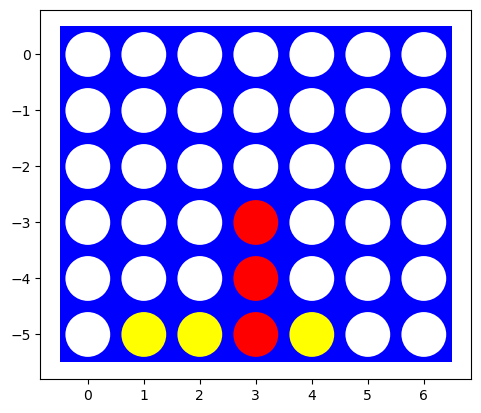

In [2]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [64]:
# Your code/ answer goes here.
def actions(s):
    action = []
    col_open_spaces = []

    for i in range(len(s[0])):
            if(s[0][i] == 0):
                for j in range(len(s)):
                    if(s[j][i] == 0):
                            col_open_spaces.append(j)
                
                action.append((np.max(col_open_spaces), i))
                col_open_spaces = []

    return action


def result(s, player, a):
    r = np.copy(s)
    i, j = a
    r[i][j] = player
    return r


def check_win(state):
    s = np.copy(state)
    
    #look right
    for j in range(len(s[0])-3):
        for i in range(len(s)):
            r = s[i][j] + s[i][j+1] + s[i][j+2] + s[i][j+3]
            if(r == 4 or r == -4):
                return s[i][j]

    #look down
    for j in range(len(s[0])):
            for i in range(len(s)-3):
                d = s[i][j] + s[i+1][j] + s[i+2][j] + s[i+3][j]
                if(d == 4 or d == -4):
                    return s[i][j]

    #look diagonally right
    for j in range(len(s[0])-3):
            for i in range(len(s)-3):
                r_diag = s[i][j] + s[i+1][j+1] + s[i+2][j+2] + s[i+3][j+3]
                if(r_diag == 4 or r_diag == -4):
                    return s[i][j]

    #look diagonally left
    for j in range(3, len(s[0])):
            for i in range(len(s)-3):
                l_diag = s[i][j] + s[i+1][j-1] + s[i+2][j-2] + s[i+3][j-3]
                if(l_diag == 4 or l_diag == -4):
                    return s[i][j]

    #look to see if board is full
    top_row = 0
    for i in range(len(s[0])):
        if(s[0][i] != 0):
            top_row +=1
    if(top_row >= len(s[0])):
        return 0
    return None


def terminal(s):
    return check_win(s) != None


def other(player):
    if(player == 1): return -1
    else: return 1


def utility(s, player=1):
    result = check_win(s)
    if(result == player):
        return 1
    elif(result == 0):
        return 0
    elif(result == other(player)):
        return -1
    else:
        return None

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [75]:
# Your code/ answer goes here.
def random_player(board, player=1):
    idx = np.random.randint(len(actions(board)))
    return actions(board)[idx]


def switch_player(player, red, yellow):
    if(player == 1):
        return -1, yellow
    else:
        return 1, red
    
#Function that starts a game between two random agents,
#playing N number of games and returning the overall
#results for all of the N games.
def play(red, yellow, N = 1000):
    results = {'red (1)': 0, 'yellow (-1)': 0, 'draw': 0}
    
    for i in range(N):
        board = empty_board()
        player, fun = 1, red
        
        while True:
            a = fun(board, player)
            board = result(board, player, a)
            game_over = terminal(board)

            if(game_over):
                outcome = check_win(board)
                if(outcome == 1):
                    results['red (1)'] += 1
                elif(outcome == -1):
                    results['yellow (-1)'] += 1
                elif(outcome == 0):
                    results['draw'] += 1
                break
            
            player, fun = switch_player(player, red, yellow)   
    
    return results

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [5]:
# Your code/ answer goes here.
play(random_player, random_player, N=1000)

{'red (1)': 554, 'yellow (-1)': 443, 'draw': 3}

Random player red won 554 times, random player yellow won 443 times, and they drew 3 times. The results are interesting to me because it seems like these results are expected but at the same time they don't. I say this because they were fairly similar in the number of times they won a game of Connect4, which is expected, but the number of times they drew was so little when comparing it to the number of games that were played. It makes sense that they would get simlar numbers of games won because they both share the same random functions that are used to play, making it somewhat equal in how they play, but if they are equal in that way then why did they not draw more often?

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points] 

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [39]:
# Your code/ answer goes here.
import math

def alpha_beta_search(board, player = 1):
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):  
    v = utility(state, player)
    if(v is not None): return v, None
        
    v, move = -math.inf, None

    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        if(v2 > v):
            v, move = v2, a
            alpha = max(alpha, v)
        if(v >= beta):
            return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    v = utility(state, player)
    if(v is not None): return v, None
    
    v, move = +math.inf, None

    for a in actions(state):
        v2, a2 = max_value_ab(result(state, other(player), a), player, alpha, beta)
        if(v2 < v):
            v, move = v2, a
            beta = min(beta, v)
        if(v <= alpha): 
            return v, move
    
    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

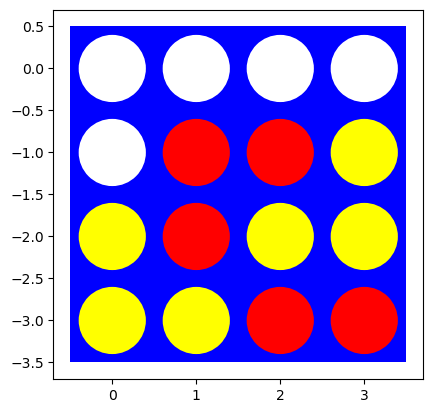

{'move': (0, 2), 'value': 0}

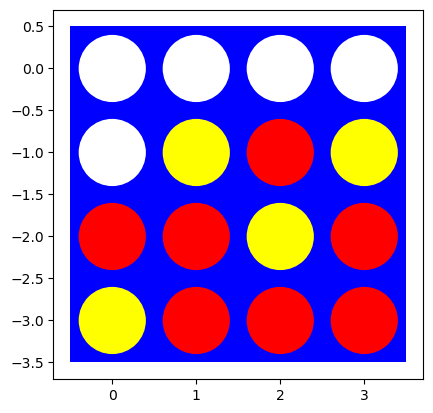

{'move': (0, 2), 'value': 0}

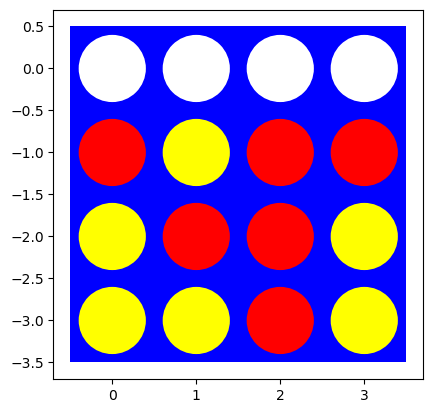

{'move': (0, 2), 'value': 1}

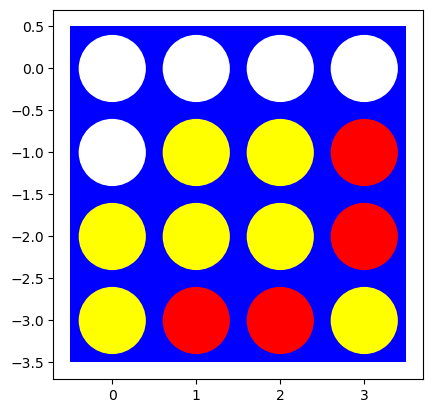

{'move': (0, 3), 'value': 0}

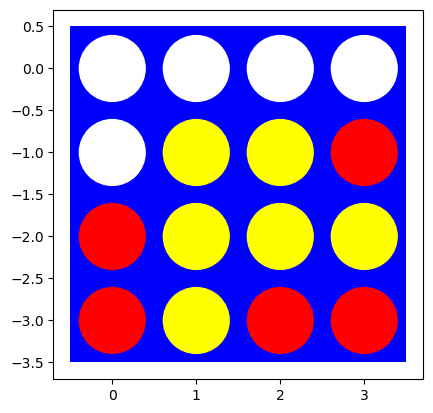

{'move': (0, 1), 'value': 0}

In [40]:
# Your code/ answer goes here.
board1 = [[0, 0, 0, 0],
         [0,1, 1, -1],
         [-1,1,-1,-1],
         [-1,-1, 1,1]]
visualize(board1)
display(alpha_beta_search(board1))


board2 = [[0, 0, 0, 0],
         [0,-1, 1, -1],
         [1,1,-1,1],
         [-1,1, 1,1]]
visualize(board2)
display(alpha_beta_search(board2))


board3 = [[0, 0, 0, 0],
         [1,-1, 1, 1],
         [-1,1,1,-1],
         [-1,-1, 1,-1]]
visualize(board3)
display(alpha_beta_search(board3))


board4 = [[0, 0, 0, 0],
         [0,-1, -1, 1],
         [-1,-1,-1,1],
         [-1,1, 1,-1]]
visualize(board4)
display(alpha_beta_search(board4))


board5 = [[0, 0, 0, 0],
         [0,-1, -1, 1],
         [1,-1,-1,-1],
         [1,-1, 1,1]]
visualize(board5)
display(alpha_beta_search(board5))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [41]:
# Your code/ answer goes here.
#4x4 board
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]
print('4x4 Board')
%time display(alpha_beta_search(board))
print('-----------------------------')


#4x5 board
board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]
print('4x5 Board')
%time display(alpha_beta_search(board))
print('-----------------------------')


#4x6 board
#board = [[0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0]]
#print('4x6 Board')
#%time display(alpha_beta_search(board))
#print('-----------------------------')

#The above code takes excessive amounts of time to run ^^



4x4 Board


{'move': (3, 2), 'value': 0}

CPU times: total: 2.5 s
Wall time: 4.2 s
-----------------------------
4x5 Board


{'move': (3, 2), 'value': 0}

CPU times: total: 1min 53s
Wall time: 3min 2s
-----------------------------


The 4x6 Connect4 board was taking excessive amounts of time to run, I had to stop running it after 13 minutes had passed.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [34]:
# Your code/ answer goes here.
def actions(s):
    action = []
    col_open_spaces = []
    priority = []

    #Moving from left to right, assign each column with a priority score if empty.

    #If there are an even number of columns, append initial priority score before incrementing by 1
    if(len(s[0])%2 == 0):
        p = 0
        for i in range(0,int(len(s[0])/2)): #From left most column to center columns, increment priority by 1
            if(s[0][i] == 0):
                priority.append(p)
                p += 1
        for i in range(int(len(s[0])/2), len(s[0])): #From center columns to right most column, decrement priority by 1
            if(s[0][i] == 0):
                p -= 1
                priority.append(p)

    #If there are an odd number of columns, append initial priority score after incrementing by 1
    else:
        p = -1
        for i in range(0,math.ceil(len(s[0])/2)): #From left most column to center column, increment priority by 1
            if(s[0][i] == 0):
                p += 1
                priority.append(p)
        for i in range(math.ceil(len(s[0])/2), len(s[0])): #From center column to right most column, decrement priority by 1
            if(s[0][i] == 0):
                p -= 1
                priority.append(p)
        
    for i in range(len(s[0])):
            if(s[0][i] == 0):
                for j in range(len(s)):
                        if(s[j][i] == 0):
                                col_open_spaces.append(j)
                action.append((np.max(col_open_spaces),i))
                col_open_spaces = []

    priority_action = [a for _,a in sorted(zip(priority,action), reverse = True)]
    return priority_action

In [35]:
#4x4 board
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]
print('4x4 Board')
%time display(alpha_beta_search(board))
print('-----------------------------')


#4x5 board
board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]
print('4x5 Board')
%time display(alpha_beta_search(board))
print('-----------------------------')


4x4 Board


{'move': (3, 2), 'value': 0}

CPU times: total: 2.59 s
Wall time: 4.17 s
-----------------------------
4x5 Board


{'move': (3, 2), 'value': 0}

CPU times: total: 2min 5s
Wall time: 3min
-----------------------------


In [36]:
import pandas as pd

strategies = {'Strategy & Board' : ['Move Ordering, 4x4','No Move Ordering, 4x4','Move Ordering, 4x5','No Move Ordering, 4x5'], 
        'Runtime' : ['4.17 s', '4.51 s', '3min', '3min 3s']}

comparison = pd.DataFrame(strategies)
display(comparison)

,Strategy & Board,Runtime
0,"Move Ordering, 4x4",4.17 s
1,"No Move Ordering, 4x4",4.51 s
2,"Move Ordering, 4x5",3min
3,"No Move Ordering, 4x5",3min 3s


From the table above, it appears that move ordering improves the run time for both boards (4x4 and 4x5). Most likely, this is due to the prioritization of moves. The difference seems to be more noticeable as the boards become larger, in this case there was a 3 second difference for the 4x5 board as opposed to the 0.34 second difference for the 4x4 board. There could be other factors that come into play, for example if the number of columns is odd or even. Perhaps, it is in the favor of move ordering if the number of columns is odd because it can prioritize the center of the board better as only one column has the highest priority as opposed to two columns for a board with an even number of columns.

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [42]:
# Your code/ answer goes here.
def openings(state,player=1):
    s = np.copy(state)
    starting_actions_col = []

    #Narrow the area where the agent can
    if(len(s[0])%2 == 0):
        for i in range(int(len(s[0])/2)-2,int(len(s[0])/2)+2):
            starting_actions_col.append(i)
    elif(len(s[0])%2 != 0):
        for i in range(math.ceil(len(s[0])/2)-2,math.ceil(len(s[0])/2)+1):
            starting_actions_col.append(i)

    search_boundaries = []

    for row in range(len(s)-3,len(s)):
        conv_row = []
        for col in starting_actions_col:
            conv_row.append(s[row][col])
        search_boundaries.append(conv_row)

    a, v = list(alpha_beta_search(search_boundaries, player=1).values())
    idx = a[1]
    col = starting_actions_col[a[1]]

    action = []
    for row in range(len(s)):
        if(s[row][col] == 0):
            action.append(row)

    return (np.max(action),col), v

With the above code, we are limiting the search space the agent is looking at. Additionally, we are narrowing the search space in an area of the board that has greater priority due to the numerous ways one can possibly win a game of Connect4. By reducing the space the agent has to search through, we can improve the runtime for the initial move on an empty board.

In [56]:
def alpha_beta_openings(board, player=1):
    b = np.copy(board)
    if(np.count_nonzero(b) < 4):
        a, v = openings(board,player)
        return {"move": a, "value": v}
                
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    return {"move": move, "value": value}

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [49]:
# Your code/ answer goes here.
def alpha_beta_play(red, yellow, N = 1000):
    results = {'red': 0, 'yellow': 0, 'draw': 0}
    
    for i in range(N):
        board = empty_board(shape=(4,4))
        player, fun = 1, red
        
        while True:
            a = fun(board, player)
            board = result(board, player, a)
            
            game_over = terminal(board)
            if(game_over):
                outcome = check_win(board)
                if(outcome == 1):
                    results['red'] += 1
                elif(outcome == -1):
                    results['yellow'] += 1
                elif(outcome == 0):
                    results['draw'] += 1
                break
            
            player, fun = switch_player(player, red, yellow)   
    
    return results

In [50]:
def alpha_beta_player(board,player=1):
    return list(alpha_beta_openings(board,player).values())[0]

In [54]:
%time display(alpha_beta_play(alpha_beta_player, random_player, N = 1000))

{'red': 732, 'yellow': 0, 'draw': 268}

CPU times: total: 1min 5s
Wall time: 1min 41s


From the above results, we can see that the minimax search agent performs better than the randomized agent by a significant margin. Out of 1000 games, the minimax search agent won 732 times, the randomized agent 0 times, and they drew 268 times.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [55]:
# Your code/ answer goes here.
def neighbors_to_score(adjacent,player):
    player_chips = 0
    opponent_chips = 0
    spaces = 0
    score = 0

    for p in adjacent:
        if(p == player):
            player_chips += 1
        elif(p == -player):
            opponent_chips += 1
        else:
            spaces += 1

    if(player_chips == 2 and spaces == 2):
        score = 1
    elif(player_chips == 2):
        score = 0.5
    elif(player_chips == 3 or opponent_chips == 3):
        score = 2
    elif(player_chips == 1):
        score = 0.5

    return score


def heuristic_neighbors(state, player = 1):
    s = state.copy()

    if(utility(state, player) != None): return utility(state,player), True
    score = 0

    #look right
    for j in range(len(s[0])-3):
        for i in range(len(s)):
            r = [s[i][j], s[i][j+1], s[i][j+2], s[i][j+3]]
            score += neighbors_to_score(r, player)
    
    #look down
    for j in range(len(s[0])):
        for i in range(len(s)-3):
            d = [s[i][j], s[i+1][j], s[i+2][j], s[i+3][j]]
            score += neighbors_to_score(d, player)

    #look diagonally right
    for j in range(len(s[0])-3):
        for i in range(len(s)-3):
            r_diag = [s[i][j], s[i+1][j+1], s[i+2][j+2], s[i+3][j+3]]
            score += neighbors_to_score(r_diag, player)

    #look diagonally left
    for j in range(3,len(s[0])):
        for i in range(len(s)-3):
            l_diag = [s[i][j], s[i+1][j-1], s[i+2][j-2], s[i+3][j-3]]
            score += neighbors_to_score(l_diag, player)

    return score, False

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [57]:
# Your code/ answer goes here.
def alpha_beta_search_cutoff(board, cutoff = None, player = 1):
    value, move = max_value_ab_cutoff(board, player, -math.inf, +math.inf, 0, cutoff)
    return {"move" : move, "value" : value}

def max_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    v, game_over = heuristic_neighbors(state, player)
    if((cutoff != None and depth >= cutoff) or game_over):
        if(game_over):
            alpha, beta = v, v
        return v, None
    
    v, move = -math.inf, None

    for a in actions(state):
        v2, a2 = min_value_ab_cutoff(result(state, player, a), player, alpha, beta, depth+1, cutoff)
        if(v2 >v):
            v, move = v2, a
            alpha = max(alpha, v)
        if(v>= beta): return v, move

    return v, move

def min_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    v, game_over = heuristic_neighbors(state, player)
    if((cutoff != None and depth >= cutoff) or game_over):
        if(game_over):
            alpha, beta = v, v
        return v, None
    
    v, move = +math.inf, None

    for a in actions(state):
        v2, a2 = max_value_ab_cutoff(result(state, other(player), a), player, alpha, beta, depth+1, cutoff)
        if(v2 < v):
            v, move = v2, a
            beta = min(beta, v)
        if(v <= alpha): return v, move

    return v, move

def alpha_beta_cutoff_openings(board, cutoff=None, player=1):
    b = np.copy(board)
    if(np.count_nonzero(b) < 6):
        a, v = openings(board,player)
        return {"move": a, "value": v}
                
    value, move = max_value_ab_cutoff(board, player, -math.inf, +math.inf, 0, cutoff)
    return {"move": move, "value": value}

In [66]:
#6x7 board
#cutoff = 10

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

%time display(alpha_beta_cutoff_openings(board, cutoff=10))

{'move': (5, 2), 'value': 0}

CPU times: total: 0 ns
Wall time: 6 ms


In [67]:
#4x4 board
#cutoff = 10

board = [[0, 0, 0, 0],
         [0, -1, 1, 1],
         [0, 1, -1, -1],
         [1, 1, -1, 1]]

%time display(alpha_beta_cutoff_openings(board, cutoff=10))

{'move': (0, 3), 'value': 1}

CPU times: total: 0 ns
Wall time: 6.86 ms


In [68]:
#4x4 board
#cutoff = 5

board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [-1, -1, 1, 0],
         [1, 1, -1, 1]]

%time display(alpha_beta_cutoff_openings(board, cutoff=5))

{'move': (1, 0), 'value': 9.0}

CPU times: total: 0 ns
Wall time: 7 ms


Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

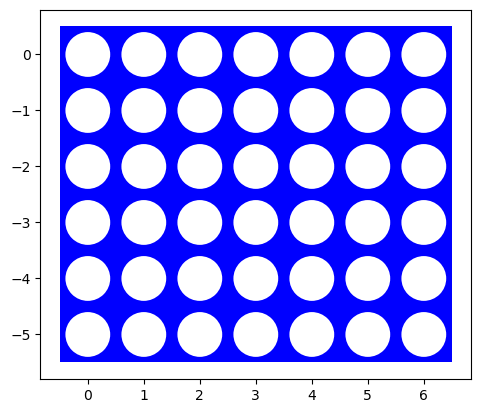

{'move': (5, 2), 'value': 0}

CPU times: total: 0 ns
Wall time: 3.81 ms


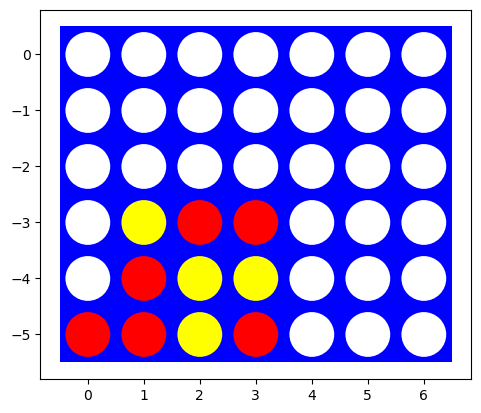

{'move': (2, 1), 'value': 37.0}

CPU times: total: 1min 54s
Wall time: 2min 55s


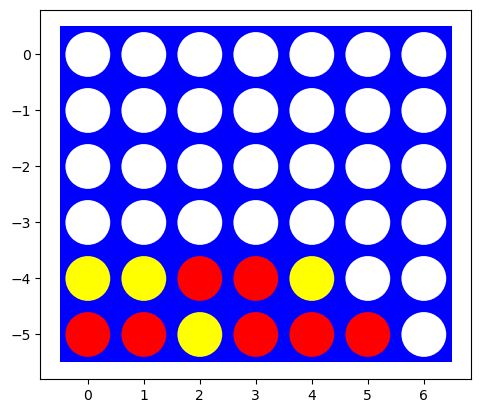

{'move': (3, 2), 'value': 37.5}

CPU times: total: 141 ms
Wall time: 229 ms


In [80]:
# Your code/ answer goes here.
#6x7 board
#cutoff = 10

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

visualize(board)
%time display(alpha_beta_cutoff_openings(board, cutoff=10))

#4x4 board
#cutoff = 10

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, -1, 1, 1, 0, 0, 0],
         [0, 1, -1, -1, 0, 0, 0],
         [1, 1, -1, 1, 0, 0, 0]]
visualize(board)
%time display(alpha_beta_cutoff_openings(board, cutoff=10))

#4x4 board
#cutoff = 5

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [-1, -1, 1, 1, -1, 0, 0],
         [1, 1, -1, 1, 1, 1, 0]]
visualize(board)
%time display(alpha_beta_cutoff_openings(board, cutoff=5))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [71]:
# Your code/ answer goes here.
board = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]

%time display(alpha_beta_cutoff_openings(board, cutoff=10))


board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]

%time display(alpha_beta_cutoff_openings(board, cutoff=10))


board = [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]]

%time display(alpha_beta_cutoff_openings(board, cutoff=10))


board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

%time display(alpha_beta_cutoff_openings(board, cutoff=10))

{'move': (3, 0), 'value': 0}

CPU times: total: 0 ns
Wall time: 50.5 ms


{'move': (3, 1), 'value': 0}

CPU times: total: 0 ns
Wall time: 4 ms


{'move': (3, 1), 'value': 0}

CPU times: total: 15.6 ms
Wall time: 52 ms


{'move': (3, 2), 'value': 0}

CPU times: total: 0 ns
Wall time: 4 ms


It takes little to no time to make a move, especially for the board that have an odd number of columns. As mentioned before as a potential idea, because odd numbers of columns have a single more prioritized center column, it takes less time to prioritize moves when compared to board of even numbers of columns. Overall, using openings and cutoffs helps improve the starting move significantly.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [77]:
# Your code/ answer goes here.
def alpha_beta_cutoff_player(board,player=1):
    return list(alpha_beta_cutoff_openings(board, cutoff=5).values())[0]

In [78]:
%time display(play(alpha_beta_cutoff_player, alpha_beta_cutoff_player, N=1))

{'red (1)': 1, 'yellow (-1)': 0, 'draw': 0}

CPU times: total: 1.69 s
Wall time: 2.23 s


## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [88]:
# Your code/ answer goes here.
def playout(state, action, player = 1):
    state = result(state, player, action)
    current_player = other(player)
    
    while True:
        util = utility(state, player)
        if util != None: return(util)
        
        idx = np.random.randint(len(actions(board)))
        a = actions(board)[idx]
        state = result(state, current_player, a)
        
        current_player = other(current_player)

def playouts(board, action, player = 1, N = 100):
    return [playout(board, action, player) for i in range(N)]

In [89]:
def pure_monte_carlo_search(board, N=100, player=1):
    a = actions(board)
    num_playouts = math.floor(N/len(a))
    plays = { i : np.mean(playouts(board, i, player, N = num_playouts)) for i in a }

    action = max(plays, key=plays.get)
    return action

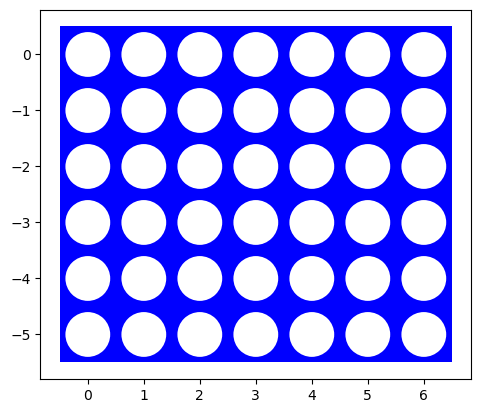

(5, 4)

CPU times: total: 1.38 s
Wall time: 2.18 s


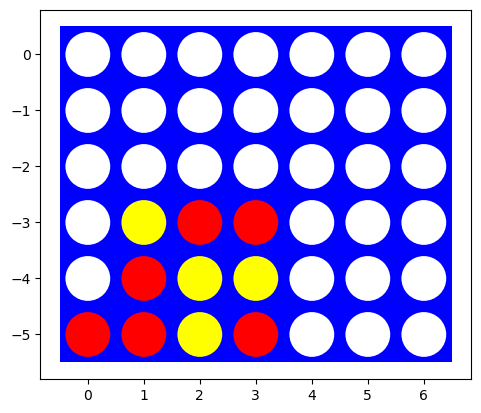

(4, 0)

CPU times: total: 469 ms
Wall time: 861 ms


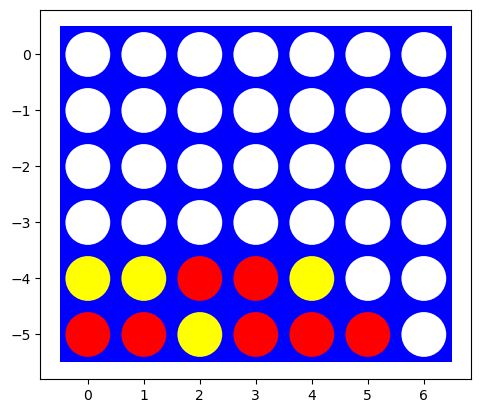

(5, 6)

CPU times: total: 625 ms
Wall time: 887 ms


In [90]:
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]

visualize(board)
%time display(pure_monte_carlo_search(board, N=1000))

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, -1, 1, 1, 0, 0, 0],
         [0, 1, -1, -1, 0, 0, 0],
         [1, 1, -1, 1, 0, 0, 0]]
visualize(board)
%time display(pure_monte_carlo_search(board, N=1000))

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [-1, -1, 1, 1, -1, 0, 0],
         [1, 1, -1, 1, 1, 1, 0]]
visualize(board)
%time display(pure_monte_carlo_search(board, N=1000))

### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [91]:
# Your code/ answer goes here.
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]
%time print(pure_monte_carlo_search(board, N = 25000))

(5, 3)
CPU times: total: 33.8 s
Wall time: 53.1 s


From the run above, we can come to a conclusion that the best move to start a game is at (5,3). This is the "best" first move because it is the position in which you get the most ways to connect four chips in a row. You can theoretically Connect4 going upwards from (5,3), leftwards from (5,3) and rightwards from (5,3).